<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Garden_Nerd_Multi_Model_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive to store model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Get Data from link

In [0]:
!wget https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip

--2019-09-15 10:05:07--  https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip
Resolving he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)... 52.219.32.247
Connecting to he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)|52.219.32.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948965311 (905M) [application/zip]
Saving to: ‘HE_Challenge_data.zip’

HE_Challenge_data.z 100%[===================>] 905.00M  10.5MB/s    in 93s     

2019-09-15 10:06:46 (9.74 MB/s) - ‘HE_Challenge_data.zip’ saved [948965311/948965311]



### Extract data from zip and delete archive

In [0]:
!unzip HE_Challenge_data.zip

In [0]:
!rm HE_Challenge_data.zip

### Import required Libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks.tracker import ReduceLROnPlateauCallback, SaveModelCallback
from fastai.callbacks import CSVLogger
from fastai.torch_core import uniform, uniform_int, log_uniform

### Setup file paths

In [0]:
WEIGHTS_PATH = Path('drive/My Drive/Garden Nerd')
DATA_PATH = Path('data')

### Modify train csv to get appropriate images from path

In [0]:
data = pd.read_csv(DATA_PATH/'train.csv')
# suffix can be given in ImageList arguement
data['image_id'] = 'train/' + data['image_id'].astype(str)
print(data.head())
data.to_csv(DATA_PATH/'mod_train.csv', index=False)

  image_id  category
0  train/0        77
1  train/1        81
2  train/2        52
3  train/3        72
4  train/4        58


### Setup Image Transforms and Image data blocks

In [0]:
tfms = get_transforms(flip_vert=False, max_zoom=1.2, 
                      max_warp=0, do_flip=False, xtra_tfms=[cutout()])

def return_data(size, bs):
    return (ImageList.from_csv(path=DATA_PATH, csv_name='mod_train.csv', suffix=".jpg")
            .split_by_rand_pct()
            .label_from_df()
            .add_test_folder(test_folder=DATA_PATH/'test')
            .transform(tfms, size=size)
            .databunch(num_workers=2, bs=bs)
            .normalize(imagenet_stats)
    )

In [0]:
data = return_data(size=128, bs=128)

print("Total flower classes in data:", len(data.classes))

Total flower classes in data: 102


## ResNet18 Model


In [0]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])\
            .mixup()\
            .to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 42130753.56it/s]


### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.45E-02


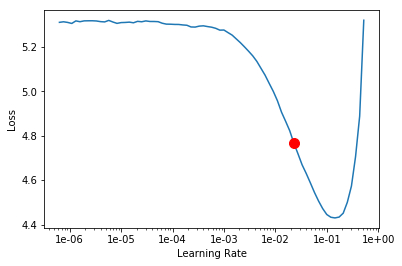

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

### Set up callbacks

In [0]:
callbacks_list = [
    ReduceLROnPlateauCallback(learn=learn, monitor='error_rate', factor=1e-6,
                              patience=5, min_delta=1e-5),

    SaveModelCallback(learn, mode="max", every='improvement',
                      monitor='accuracy', name='best'),
    CSVLogger(learn=learn, append=True)
]

### Train model

In [0]:
learn.fit_one_cycle(5, min_grad_lr, callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.581463,1.252792,0.327940,0.672060,03:19
1,2.095495,0.857355,0.229234,0.770766,03:18
2,1.820103,0.520460,0.129989,0.870011,03:12
3,1.599638,0.308248,0.058522,0.941478,03:08
4,1.459175,0.270733,0.047195,0.952805,03:08


Better model found at epoch 0 with accuracy value: 0.6720604300498962.
Better model found at epoch 1 with accuracy value: 0.7707659006118774.
Better model found at epoch 2 with accuracy value: 0.8700107932090759.
Better model found at epoch 3 with accuracy value: 0.94147789478302.
Better model found at epoch 4 with accuracy value: 0.9528047442436218.


### Interpret results

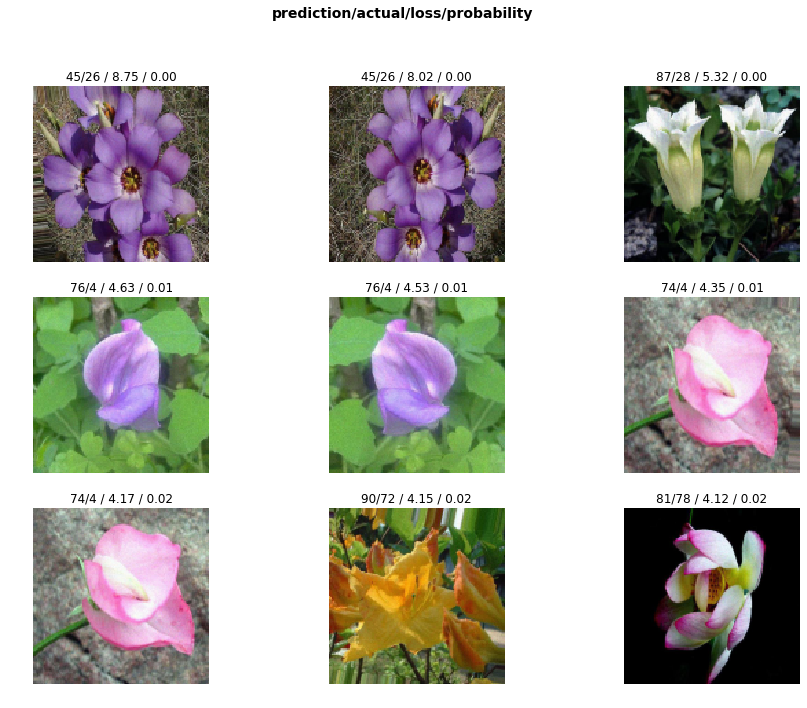

In [0]:
learn.load('best')
# learn.to_fp32()
learn.interpret().plot_top_losses(9, figsize=(15,11))

### View Predictions on train data

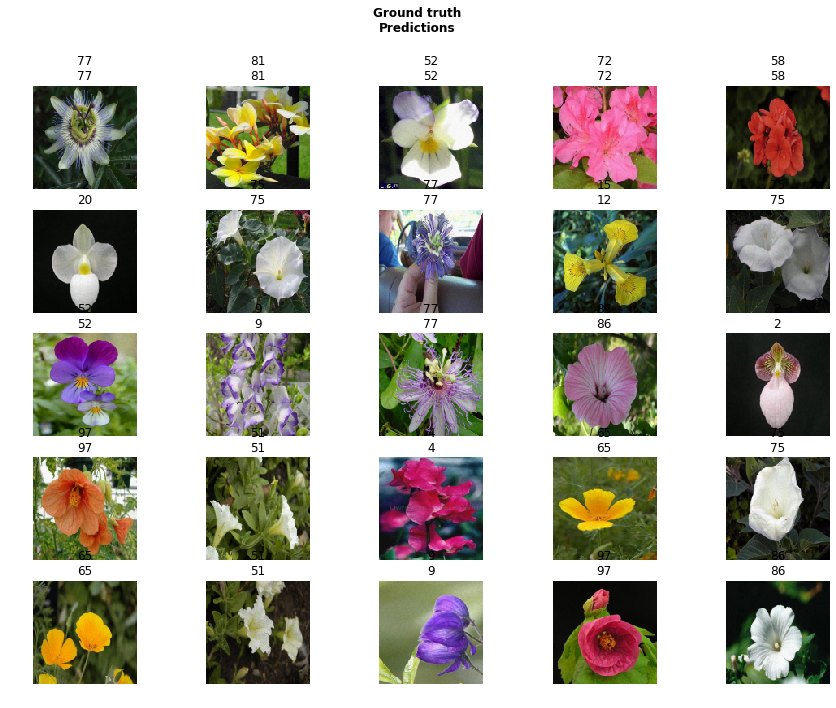

In [0]:
learn.show_results(9, figsize=(15,11))

### Save Model weights

In [0]:
learn.load("best");
learn.to_fp32()
learn.export("garden_he_resnet18_st1.pkl")
learn.save("garden_he_resnet18_st1_wgts")

### Backup model weights to drive

In [0]:
!cp data/garden_he_resnet34_st1.pkl 'drive/My Drive/Garden Nerd'
!cp data/models/garden_he_resnet34_st1_wgts.pth 'drive/My Drive/Garden Nerd'

### Fine tune model

In [0]:
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


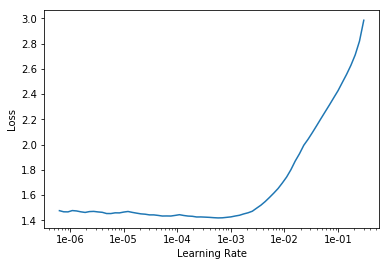

In [0]:
learn.recorder.plot()
# min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(2, slice(2e-6, 1e-5), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.455828,0.258672,0.043959,0.956041,03:14
1,1.435212,0.256878,0.042880,0.957120,03:11


Better model found at epoch 0 with accuracy value: 0.9560409784317017.
Better model found at epoch 1 with accuracy value: 0.9571197628974915.


### Train with bigger data

In [0]:
learn.data = return_data(size=224, bs=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


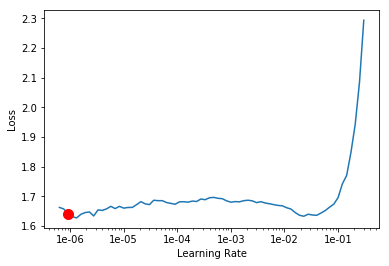

In [0]:
learn.load('best');
learn.to_fp16()
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(10, slice(min_grad_lr/10, min_grad_lr), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,time
0,2.329673,1.064161,0.255448,05:43
1,1.820806,0.480763,0.100863,05:44
2,1.581807,0.323663,0.059978,05:44
3,1.472755,0.262207,0.046063,05:44
4,1.417830,0.230149,0.037433,05:43
5,1.389498,0.205914,0.029234,05:44
6,1.338910,0.188780,0.027292,05:44
7,1.302783,0.179531,0.025458,05:44
8,1.297829,0.175780,0.023840,05:44
9,1.304932,0.171916,0.023732,05:45


Better model found at epoch 0 with error_rate value: 0.2554476857185364.
Better model found at epoch 1 with error_rate value: 0.1008630022406578.
Better model found at epoch 2 with error_rate value: 0.0599784255027771.
Better model found at epoch 3 with error_rate value: 0.046062566339969635.
Better model found at epoch 4 with error_rate value: 0.03743257746100426.
Better model found at epoch 5 with error_rate value: 0.029234088957309723.
Better model found at epoch 6 with error_rate value: 0.027292340993881226.
Better model found at epoch 7 with error_rate value: 0.02545846812427044.
Better model found at epoch 8 with error_rate value: 0.023840345442295074.
Better model found at epoch 9 with error_rate value: 0.023732470348477364.


In [0]:
learn.load("best");
learn.to_fp32()
learn.export("garden_he_resnet18_st2_224.pkl")
learn.save("garden_he_resnet18_st2_224")

### Fine tune the model again

In [0]:
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


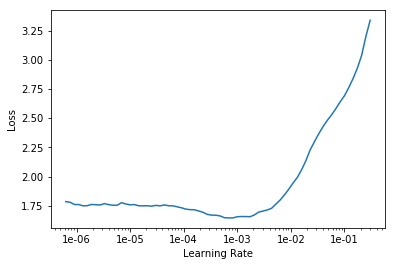

In [0]:
learn.recorder.plot()
# min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(5, slice(1e-7, 1e-6), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,time
0,1.266411,0.175684,0.023517,05:54
1,1.291158,0.173814,0.024595,05:52
2,1.289662,0.173340,0.023840,05:54
3,1.297453,0.173771,0.023840,05:55
4,1.306263,0.173640,0.023193,05:56


Better model found at epoch 0 with error_rate value: 0.023516720160841942.
Better model found at epoch 4 with error_rate value: 0.02319309674203396.


In [0]:
learn.load('best');
learn.to_fp32();

### Backup model weights to drive

In [0]:
!cp data/garden_he_resnet34_st1_224.pkl 'drive/My Drive/Garden Nerd'
!cp data/models/garden_he_resnet34_st1_224.pth 'drive/My Drive/Garden Nerd'

## VGG 16

In [0]:
data = return_data(size=399, bs=16)

In [0]:
learn_vgg = cnn_learner(data, models.vgg16_bn, metrics=[error_rate, accuracy])\
            .mixup()\
            .to_fp16()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:14<00:00, 39485950.48it/s]


### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.20E-02


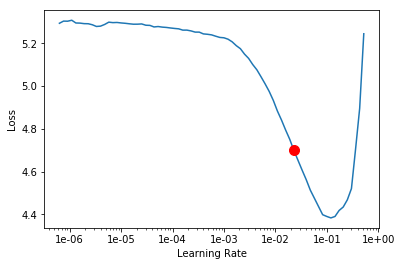

In [0]:
learn_vgg.lr_find()
learn_vgg.recorder.plot(suggestion=True)
min_grad_lr = learn_vgg.recorder.min_grad_lr

### Set up callbacks

In [0]:
callbacks_list = [
    ReduceLROnPlateauCallback(learn=learn_vgg, monitor='error_rate', factor=1e-6,
                              patience=5, min_delta=1e-5),

    SaveModelCallback(learn_vgg, mode="max", every='improvement',
                      monitor='accuracy', name='best'),
    CSVLogger(learn=learn_vgg, append=True)
]

### Train model

In [0]:
learn_vgg.fit_one_cycle(6, min_grad_lr, callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.419303,0.838172,0.228964,0.771036,03:42
1,2.009862,0.915703,0.251888,0.748112,03:35
2,1.754160,0.478929,0.113269,0.886731,03:35
3,1.581341,0.337963,0.068501,0.931499,03:33
4,1.445105,0.194405,0.029935,0.970065,03:32
5,1.347358,0.177050,0.022923,0.977077,03:36


Better model found at epoch 0 with accuracy value: 0.7710356116294861.
Better model found at epoch 2 with accuracy value: 0.8867313861846924.
Better model found at epoch 3 with accuracy value: 0.9314994812011719.
Better model found at epoch 4 with accuracy value: 0.9700646996498108.
Better model found at epoch 5 with accuracy value: 0.9770765900611877.


### Interpret results

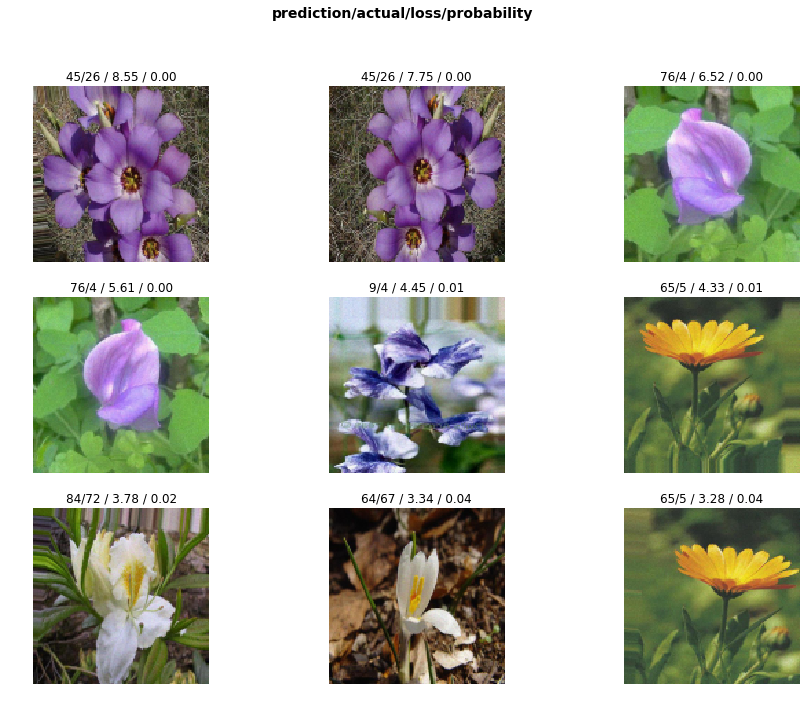

In [0]:
learn_vgg.load('best');
# learn_vgg.to_fp32()
learn_vgg.interpret().plot_top_losses(9, figsize=(15,11))

### View Predictions on train data

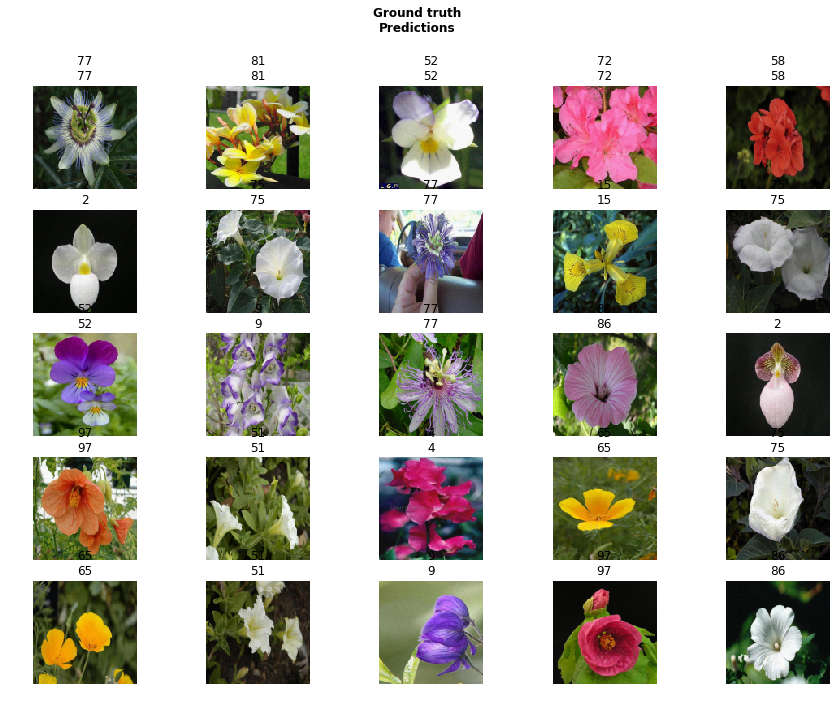

In [0]:
learn_vgg.show_results(9, figsize=(15,11))

### Save Model weights

In [0]:
learn_vgg.load("best");
learn_vgg.to_fp32()
learn_vgg.export("garden_he_vgg16_st1.pkl")
learn_vgg.save("garden_he_vgg16_st1_wgts")

### Backup model weights to drive

In [0]:
!cp data/garden_he_resnet34_st1.pkl 'drive/My Drive/Garden Nerd'
!cp data/models/garden_he_resnet34_st1_wgts.pth 'drive/My Drive/Garden Nerd'

### Fine tune model

In [0]:
learn_vgg.to_fp16()
learn_vgg.unfreeze()
learn_vgg.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


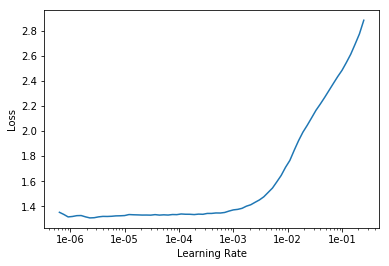

In [0]:
learn_vgg.recorder.plot()
# min_grad_lr = learn_vgg.recorder.min_grad_lr

In [0]:
learn_vgg.fit_one_cycle(2, slice(2e-6, 1e-5), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.313948,0.167175,0.021036,0.978964,03:53
1,1.319962,0.166298,0.021845,0.978155,03:55


Better model found at epoch 0 with accuracy value: 0.9789643883705139.


### Train with bigger data

In [0]:
learn_vgg.data = return_data(size=399, bs=16)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 5.75E-03


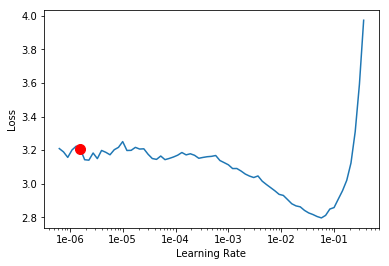

In [0]:
learn_vgg.load('best');
learn_vgg.to_fp16()
learn_vgg.freeze()
learn_vgg.lr_find()
learn_vgg.recorder.plot(suggestion=True)
min_grad_lr = learn_vgg.recorder.min_grad_lr

In [0]:
learn_vgg.fit_one_cycle(4, slice(1e-3/2, 1e-3), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.777931,0.440809,0.091154,0.908846,17:37
1,1.506566,0.218396,0.039374,0.960626,17:35
2,1.498330,0.175866,0.024002,0.975998,17:31
3,1.451963,0.175713,0.022923,0.977077,17:30


Better model found at epoch 0 with accuracy value: 0.9088457226753235.
Better model found at epoch 1 with accuracy value: 0.9606256484985352.
Better model found at epoch 2 with accuracy value: 0.9759978652000427.
Better model found at epoch 3 with accuracy value: 0.9770765900611877.


In [0]:
learn_vgg.load("best");
learn_vgg.to_fp32()
learn_vgg.export("garden_he_vgg_st2_224.pkl")
learn_vgg.save("garden_he_vgg_st2_224")

### Fine tune the model again

In [0]:
learn_vgg.to_fp16()
learn_vgg.unfreeze()
learn_vgg.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


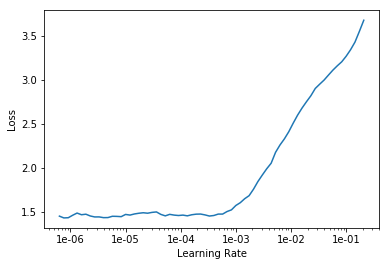

In [0]:
learn_vgg.recorder.plot()
# min_grad_lr = learn_vgg.recorder.min_grad_lr

In [0]:
learn_vgg.fit_one_cycle(1, slice(1e-7, 1e-6), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,accuracy,time


In [0]:
learn_vgg.load('best');
learn_vgg.to_fp32();

### Backup model weights to drive

In [0]:
!cp data/garden_he_resnet34_st1_224.pkl 'drive/My Drive/Garden Nerd'
!cp data/models/garden_he_resnet34_st1_224.pth 'drive/My Drive/Garden Nerd'

## Ensemble

### Predict with test data

In [0]:
sample_df = pd.read_csv(DATA_PATH/"sample_submission.csv")

In [0]:
sample_df.head()

,image_id,category
0,18540,0
1,18541,0
2,18542,0
3,18543,0
4,18544,0


In [0]:
learn.data.add_test(ImageList.from_df(sample_df, DATA_PATH,folder='test',suffix='.jpg'))

In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred))+1)

sample_df['category'] = labelled_preds

In [0]:
sample_df.to_csv('submission.csv', index=False)